In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn import utils
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data1=pd.read_excel('/content/농산물_수입량_수입가격.xlsx',sheet_name=0)
data2=pd.read_excel('/content/농산물_수입량_수입가격.xlsx',sheet_name=1)

In [ ]:
print(pd.isnull(data1).sum())
print(pd.isnull(data2).sum())

날짜     0
쌀      0
팥      0
콩      0
녹두     0
메밀     0
기타콩    0
dtype: int64
날짜     0
쌀      0
팥      0
콩      0
녹두     0
메밀     0
기타콩    0
dtype: int64


In [3]:
df=pd.merge(data1,data2,on='날짜')
#x가 가격 y가 수입량
#데이터분리
dataa=df[(df['날짜']<'2020-05-01')]
testt=df[(df['날짜']>='2020-05-01')]

#쌀 가격과 수입량

In [43]:
rice=dataa[['쌀_x','쌀_y']]
data=rice.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(63, 7, 2)
(63, 2)
(23, 7, 2)
(23, 2)


In [35]:
x_train[0].shape

(7, 2)

In [44]:
input = Input(shape=(sequence_length, 2))

net = LSTM(units=10)(input) 
net = Dense(units=2)(net)
model = Model(inputs=input, outputs=net)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 7, 2)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                520       
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 2s 482ms/step - loss: 0.2480 - val_loss: 0.1431
Epoch 2/60
2/2 [==============================] - 0s 27ms/step - loss: 0.1280 - val_loss: 0.0745
Epoch 3/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0712 - val_loss: 0.0644
Epoch 4/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0687 - val_loss: 0.0822
Epoch 5/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0843 - val_loss: 0.0847
Epoch 6/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0826 - val_loss: 0.0731
Epoch 7/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0714 - val_loss: 0.0638
Epoch 8/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0639 - val_loss: 0.0601
Epoch 9/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0609 - val_loss: 0.0601
Epoch 10/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0621 - val_loss: 0.0612
Epoch 11/60
2/2 [===========

In [46]:
y_predict = model.predict(x_test)
y_predict_inverse=transformer.inverse_transform(y_predict)
y_test_inverse=transformer.inverse_transform(y_test)

In [47]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test_inverse,y_predict_inverse)

1.3211743347884264

In [40]:
dataa

,날짜,쌀_x,팥_x,콩_x,녹두_x,메밀_x,기타콩_x,쌀_y,팥_y,콩_y,녹두_y,메밀_y,기타콩_y
0,2012-01-01,17309411.0,484953.0,621207.0,46952.0,223017.0,335535.0,14390615.0,694428,298470,58548,70110,408319
1,2012-02-01,7465279.0,607139.0,532087.0,0.0,0.0,140125.0,6279896.0,640202,289048,0,0,190148
2,2012-03-01,22486603.0,3429365.0,894162.0,0.0,120000.0,247573.0,18238124.0,3674904,362021,0,37680,321311
3,2012-04-01,22642156.0,2272238.0,1166611.0,1051500.0,571566.0,204449.0,19195746.0,2910072,539112,977476,350293,271190
4,2012-05-01,37076936.0,5993527.0,1127110.0,21201.0,380000.0,279031.0,30108629.0,6158674,664481,23296,216664,356704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2019-12-01,59502422.4,6771540.2,1033037.6,1293054.9,340039.9,217934.9,45110763.0,7356527,748115,1645448,217329,255103
96,2020-01-01,106904185.6,2850398.2,945429.0,1148207.0,675047.6,189360.7,64001710.0,3262698,625794,1546378,599787,625794
97,2020-02-01,35022103.7,1115764.0,929753.3,65355.7,261.7,178132.3,20564947.0,1233496,606834,83205,482,213263
98,2020-03-01,38055379.1,1708941.1,895414.8,100085.1,1035.1,132976.2,31173987.0,2082290,659141,149132,1222,162522


#콩 가격과 수입량

In [48]:
bean=dataa[['콩_x','콩_y']]
data=bean.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test))
y_predict = model.predict(x_test)
y_predict_inverse=transformer.inverse_transform(y_predict)
y_test_inverse=transformer.inverse_transform(y_test)
print(mean_absolute_percentage_error(y_test_inverse,y_predict_inverse))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 2s 487ms/step - loss: 0.0527 - val_loss: 0.0323
Epoch 2/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0328 - val_loss: 0.0317
Epoch 3/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0337 - val_loss: 0.0348
Epoch 4/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0351 - val_loss: 0.0336
Epoch 5/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0328 - val_loss: 0.0313
Epoch 6/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0301 - val_loss: 0.0296
Epoch 7/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0287 - val_loss: 0.0295
Epoch 8/60
2/2 [==============================] - 0s 32ms/step - loss: 0.0283 - val_loss: 0.0297
Epoch 9/60
2/2 [==============================] - 0s 48ms/step - loss: 0.0282 - val_loss: 0.0300
Epoch 10/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 11/60
2/2 [===========

팥 가격과 수입량

In [49]:
pat=dataa[['팥_x','팥_y']]
data=pat.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test))
y_predict = model.predict(x_test)
y_predict_inverse=transformer.inverse_transform(y_predict)
y_test_inverse=transformer.inverse_transform(y_test)
print(mean_absolute_percentage_error(y_test_inverse,y_predict_inverse))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 3s 483ms/step - loss: 0.0747 - val_loss: 0.0815
Epoch 2/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0625 - val_loss: 0.0752
Epoch 3/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0573 - val_loss: 0.0729
Epoch 4/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0569 - val_loss: 0.0711
Epoch 5/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0554 - val_loss: 0.0688
Epoch 6/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0536 - val_loss: 0.0668
Epoch 7/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0518 - val_loss: 0.0657
Epoch 8/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0517 - val_loss: 0.0655
Epoch 9/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0510 - val_loss: 0.0649
Epoch 10/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0511 - val_loss: 0.0639
Epoch 11/60
2/2 [===========

#녹두 수입량과 가격

In [51]:
du=dataa[['녹두_x','녹두_y']]
data=du.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test))
y_predict = model.predict(x_test)
y_predict_inverse=transformer.inverse_transform(y_predict)
y_test_inverse=transformer.inverse_transform(y_test)
print(mean_absolute_percentage_error(y_test_inverse,y_predict_inverse))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 2s 494ms/step - loss: 0.0524 - val_loss: 0.0537
Epoch 2/60
2/2 [==============================] - 0s 25ms/step - loss: 0.0503 - val_loss: 0.0567
Epoch 3/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0506 - val_loss: 0.0579
Epoch 4/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0495 - val_loss: 0.0545
Epoch 5/60
2/2 [==============================] - 0s 32ms/step - loss: 0.0483 - val_loss: 0.0534
Epoch 6/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0484 - val_loss: 0.0536
Epoch 7/60
2/2 [==============================] - 0s 32ms/step - loss: 0.0485 - val_loss: 0.0533
Epoch 8/60
2/2 [==============================] - 0s 31ms/step - loss: 0.0479 - val_loss: 0.0534
Epoch 9/60
2/2 [==============================] - 0s 29ms/step - loss: 0.0472 - val_loss: 0.0537
Epoch 10/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0473 - val_loss: 0.0543
Epoch 11/60
2/2 [===========

#메밀 수입량과 가격

In [52]:
mill=dataa[['메밀_x','메밀_y']]
data=mill.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test))
y_predict = model.predict(x_test)
y_predict_inverse=transformer.inverse_transform(y_predict)
y_test_inverse=transformer.inverse_transform(y_test)
print(mean_absolute_percentage_error(y_test_inverse,y_predict_inverse))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 3s 486ms/step - loss: 0.1256 - val_loss: 0.0767
Epoch 2/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0607 - val_loss: 0.0468
Epoch 3/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0469 - val_loss: 0.0433
Epoch 4/60
2/2 [==============================] - 0s 29ms/step - loss: 0.0489 - val_loss: 0.0446
Epoch 5/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0511 - val_loss: 0.0444
Epoch 6/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0502 - val_loss: 0.0432
Epoch 7/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0484 - val_loss: 0.0423
Epoch 8/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0466 - val_loss: 0.0422
Epoch 9/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0465 - val_loss: 0.0427
Epoch 10/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0460 - val_loss: 0.0433
Epoch 11/60
2/2 [===========

#기타 콩 수입량과 가격

In [53]:
ect=dataa[['기타콩_x','기타콩_y']]
data=ect.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test))
y_predict = model.predict(x_test)
y_predict_inverse=transformer.inverse_transform(y_predict)
y_test_inverse=transformer.inverse_transform(y_test)
print(mean_absolute_percentage_error(y_test_inverse,y_predict_inverse))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 2s 480ms/step - loss: 0.0541 - val_loss: 0.0313
Epoch 2/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0344 - val_loss: 0.0215
Epoch 3/60
2/2 [==============================] - 0s 26ms/step - loss: 0.0304 - val_loss: 0.0184
Epoch 4/60
2/2 [==============================] - 0s 34ms/step - loss: 0.0338 - val_loss: 0.0179
Epoch 5/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0317 - val_loss: 0.0198
Epoch 6/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0293 - val_loss: 0.0201
Epoch 7/60
2/2 [==============================] - 0s 30ms/step - loss: 0.0278 - val_loss: 0.0202
Epoch 8/60
2/2 [==============================] - 0s 27ms/step - loss: 0.0279 - val_loss: 0.0214
Epoch 9/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0287 - val_loss: 0.0216
Epoch 10/60
2/2 [==============================] - 0s 28ms/step - loss: 0.0286 - val_loss: 0.0219
Epoch 11/60
2/2 [===========

여기부터 시계열 해보기


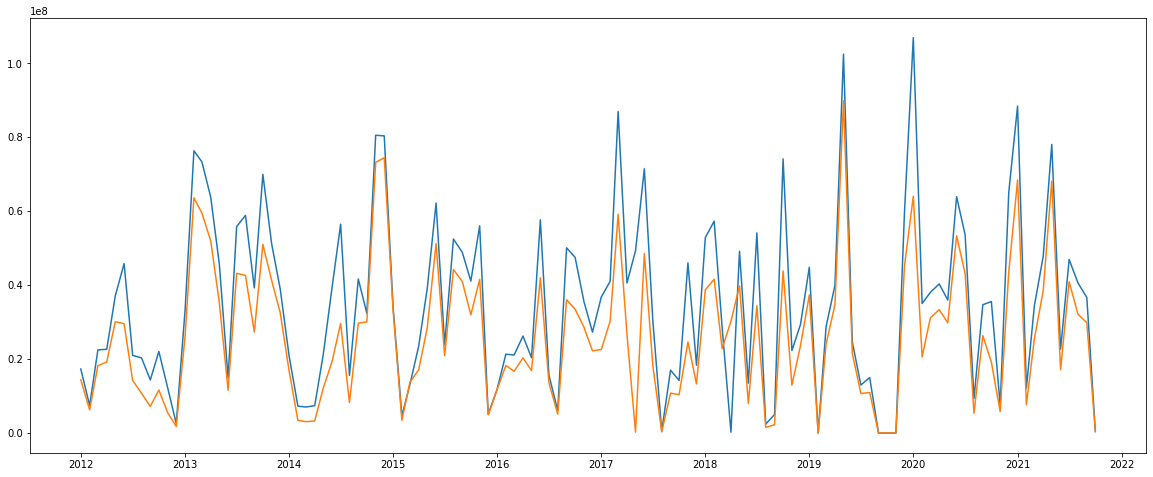

In [18]:
#eda
plt.figure(figsize=(20,8))
plt.plot(df['날짜'], df[['쌀_x','쌀_y']])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49920 missing from current font.
  font.set_text

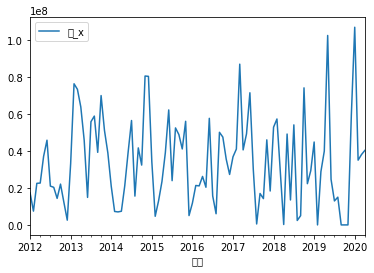

In [25]:
#쌀가격만 시계열
riceprice=dataa[['날짜','쌀_x']]
riceprice.index=riceprice['날짜']
riceprice.set_index('날짜',inplace=True)
riceprice.plot()

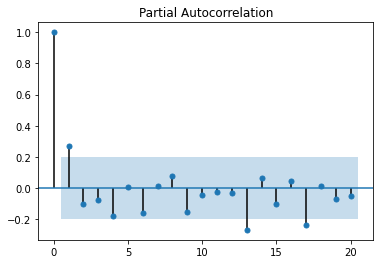

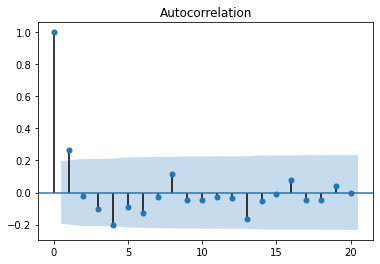

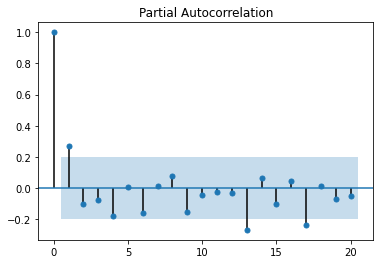

In [26]:
plot_acf(riceprice)
plot_pacf(riceprice)

In [ ]:
#시계열분석
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
model=ARIMA(riceprice, order=(1,1,0))
model_fit=model.fit(trend='nc', full_output=True, disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.쌀_x   No. Observations:                   99
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1836.266
Method:                       css-mle   S.D. of innovations       27472964.824
Date:                Wed, 24 Nov 2021   AIC                           3676.531
Time:                        06:21:51   BIC                           3681.722
Sample:                    02-01-2012   HQIC                          3678.631
                         - 04-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.D.쌀_x    -0.3030      0.095     -3.184      0.002      -0.490      -0.116
                                    Roots                                    
                  Real          Imaginary         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49920 missing from current font.
  font.set_text(s, 0, flags=flags)


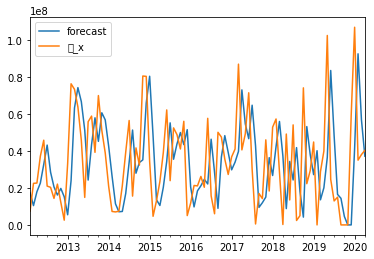

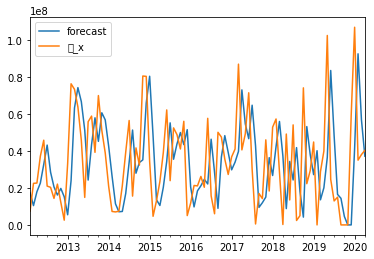

In [ ]:
model_fit.plot_predict()

In [ ]:
fore=model_fit.forecast(steps=1)
fore

(array([39627013.82537305]),
 array([27472964.82415754]),
 array([[-14219007.77851151,  93473035.42925762]]))

In [ ]:
test.iloc[0,1] #원 데이터와 비교해보니 값이 비슷하게 예측함을 알 수 있다.

35972518.1